In [1]:
import pandas as pd
from etl_resources import sqlite_connection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandasql as psql
from sklearn.preprocessing import MinMaxScaler

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

2021-11-28 19:08:49.024790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-28 19:08:49.024829: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def ticker_list():
    
    con = sqlite_connection()
    cur = con.cursor()
    cur.execute('''
    select distinct w.ticker from weekly_prices_clean w
        inner join (select ticker from weekly_prices_clean
        group by ticker
        having max(date) > '2021-01-01') t on t.ticker=w.ticker
        limit 1
    ''')
    res = cur.fetchall()
    res = [val[0] for val in res]
    
    return res

In [4]:
def base_df(ticker):
    
    '''
    This function returns the base time series dataframe (date and close)
    '''
    
    con = sqlite_connection()
        
    df = pd.read_sql(f'''select date,close 
    from weekly_prices_clean where ticker='{ticker}' and date>'2017-12-31' 
    group by date,close
    order by date asc''',con=con)
    
    df = df.filter(['close'])
        
    return df

In [5]:
def train_test_split(df, split=0.2):
    
    test_rows = int(round(df.shape[0] * split,0))
    train_rows = df.shape[0] - test_rows
    
    test_df = df.head(test_rows).copy()
    train_df = df.tail(train_rows).copy()
    
    return train_df, test_df

In [6]:
def build_lstm(x_train, y_train, x_test, y_test, scaler):
    
    
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    
    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(rmse)
    
    return predictions
    

In [7]:
def mean_abs_perc_err(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Building model for MMM


2021-11-28 19:08:50.398240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-28 19:08:50.398275: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-28 19:08:50.398294: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jameslaptop-Lenovo-Yoga-2-Pro): /proc/driver/nvidia/version does not exist
2021-11-28 19:08:50.398492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-28 19:08:50.862940: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] N

132/132 [==============================] - 6s 28ms/step - loss: 0.0122
4.228329365619566


/tmp/ipykernel_30552/262026962.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


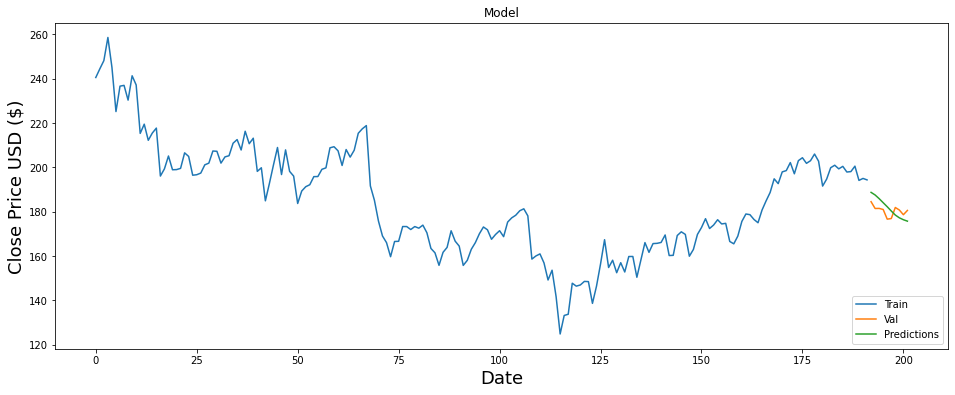

In [8]:
def main():
    # following https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm
    tickers = ticker_list()
    #metrics_list = list()
    
    for ticker in tickers:
        
        print(f"Building model for {ticker}")
        
        #metrics = dict()
        
        # Build the dataset and split
        df = base_df(ticker)
        dataset = df.values
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)
        training_data_len = int(np.ceil( len(dataset) * .95 ))
        train_data = scaled_data[0:int(training_data_len), :]
        train_data = scaled_data[0:int(training_data_len), :]
        # Split the data into x_train and y_train data sets
        x_train = []
        y_train = []
        
        for i in range(60, len(train_data)):
            x_train.append(train_data[i-60:i, 0])
            y_train.append(train_data[i, 0])
       
        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        test_data = scaled_data[training_data_len - 60: , :]
        
        # Create the data sets x_test and y_test
        x_test = []
        y_test = dataset[training_data_len:, :]
        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i, 0])
    
        # Convert the data to a numpy array
        x_test = np.array(x_test)

        # Reshape the data
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
        
        #train, test = train_test_split(df, split=0.15)
        # Train & Test LSTM
        predictions = build_lstm(x_train, y_train, x_test, y_test, scaler)
        
        train = df[:training_data_len]
        valid = df[training_data_len:]
        valid['Predictions'] = predictions
        # Visualize the data
        plt.figure(figsize=(16,6))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['close'])
        plt.plot(valid[['close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()
        

main()      